In [1]:
!pip install numpy==1.24.4
!pip uninstall -y pmdarima
!pip install pmdarima==2.0.3

Found existing installation: pmdarima 2.0.3
Uninstalling pmdarima-2.0.3:
  Successfully uninstalled pmdarima-2.0.3
  Using cached pmdarima-2.0.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.9 MB)


Mengkonfigurasi ulang pmdarima

In [3]:
# Import library utama
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Untuk statistik dan time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Model ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df1 = pd.read_csv('/content/features.csv')
df2 = pd.read_csv('/content/stores.csv')
df3 = pd.read_csv('/content/train.csv')

# Tampilkan hasil
print("feature:")
print(df1.head())
print("\nStores:")
print(df2.head())
print("\nTrain:")
print(df3.head())


feature:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  

Stores:
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4

## Tahap 1: Load Data
Pada tahap awal ini, kita melakukan proses pemuatan tiga dataset utama:
- `features.csv`: Informasi mingguan seperti harga bahan bakar, CPI, unemployment, dsb.
- `stores.csv`: Informasi tipe toko.
- `train.csv`: Data utama penjualan mingguan dari tiap toko dan departemen.

Dataset kemudian digabung (merge) berdasarkan `Store`, `Date`, dan `Dept` untuk membentuk satu dataframe komprehensif.

In [7]:
# Info data
print("Informasi dataset:")
df.info()

# Cek missing value
print("\nMissing value per kolom:")
print(df.isnull().sum())

# Statistik ringkasan
df.describe()

Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  IsHoliday_y   421570 non-null  bool          
 15

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Month,Year
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739,6.449510,2010.968591
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000,1.000000,2010.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000,4.000000,2010.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000,6.000000,2011.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000,9.000000,2012.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,12.000000,2012.000000
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328,3.243217,0.796876


##  Tahap 2: Eksplorasi Awal Data (EDA)
EDA dilakukan untuk memahami struktur dan isi data, serta mengidentifikasi potensi masalah seperti missing value, outlier, atau ketidakwajaran data. Langkah-langkah utama meliputi:
- Melihat dimensi dan tipe data.
- Menampilkan statistik deskriptif.
- Memeriksa missing value dan duplikasi.

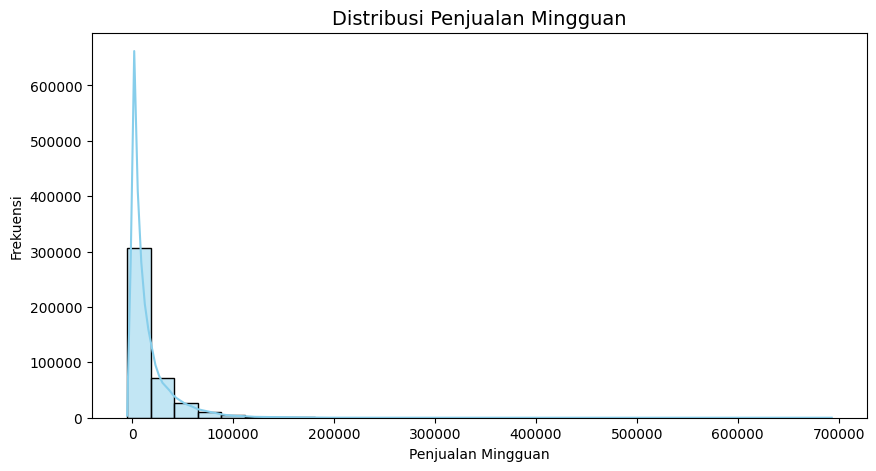

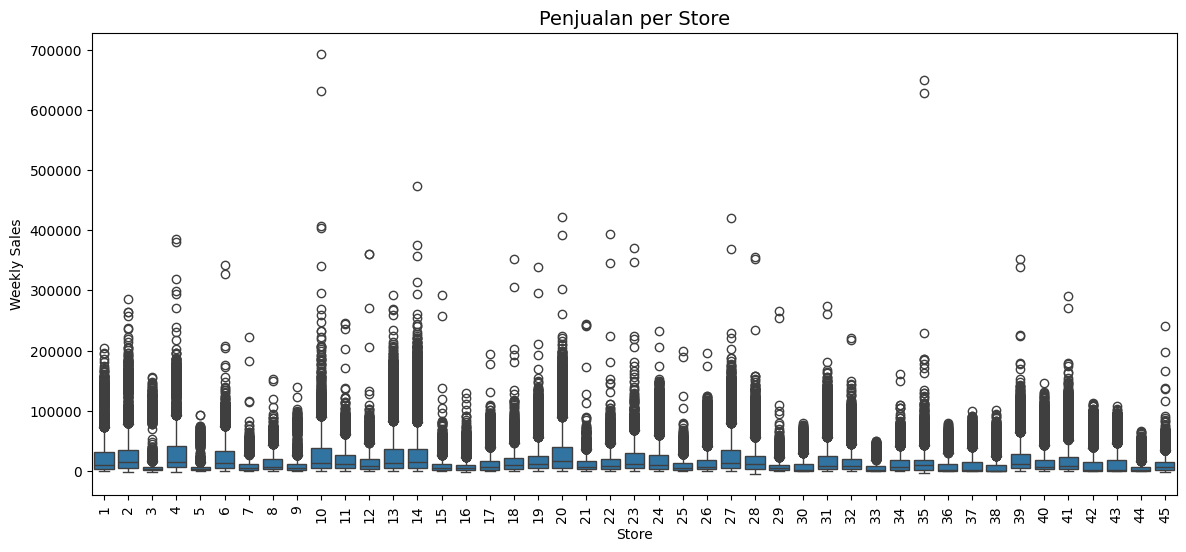

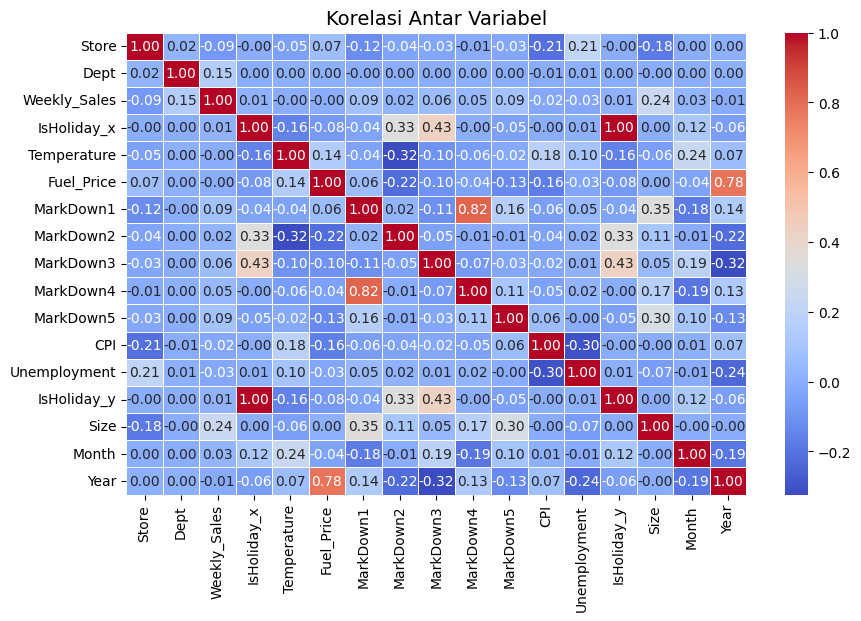

In [8]:
# Distribusi Weekly Sales
plt.figure(figsize=(10, 5))
sns.histplot(df['Weekly_Sales'], kde=True, bins=30, color='skyblue')
plt.title('Distribusi Penjualan Mingguan', fontsize=14)
plt.xlabel('Penjualan Mingguan')
plt.ylabel('Frekuensi')
plt.show()

# Boxplot Penjualan per Store
plt.figure(figsize=(14, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=df)
plt.title('Penjualan per Store', fontsize=14)
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=90)
plt.show()

# Heatmap korelasi numerik
plt.figure(figsize=(10, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korelasi Antar Variabel', fontsize=14)
plt.show()

##  Tahap 3: Visualisasi Data
Visualisasi digunakan untuk memahami hubungan antar fitur dan pola dalam data:
- Distribusi penjualan mingguan (`Weekly_Sales`).
- Korelasi antar fitur numerik dengan heatmap.
- Boxplot untuk membandingkan penjualan antar toko dan hari libur.
- Visualisasi tren musiman dan fluktuasi mingguan.

In [14]:
# Cek kolom hasil merge
print(df.columns)

# Jika ada IsHoliday_x dan IsHoliday_y, kita bisa pilih salah satu
if 'IsHoliday_x' in df.columns and 'IsHoliday_y' in df.columns:
    df['IsHoliday'] = df['IsHoliday_x']  # atau df['IsHoliday_y']
elif 'IsHoliday' not in df.columns:
    raise ValueError("Kolom IsHoliday tidak ditemukan setelah merge.")

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size',
       'Month', 'Year'],
      dtype='object')


## Tahap 4: Analisis Time Series
Data penjualan bersifat time series, maka perlu dilakukan:
- **Decompose Time Series** untuk memisahkan komponen trend, seasonal, dan residual.
- Analisis visual terhadap musiman mingguan/tahunan (52 minggu).

In [15]:
# Pilih fitur dan target
features = ['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
X = df[features]
y = df['Weekly_Sales']

# Tangani nilai kosong
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prediksi
y_pred = lr_model.predict(X_test)

# Evaluasi model
print("Evaluasi Linear Regression")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):,.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}")
print(f"R²   : {r2_score(y_test, y_pred):.4f}")


📊 Evaluasi Linear Regression
MAE  : 15,119.94
RMSE : 22,728.21
R²   : 0.0094


<ipython-input-15-e5a6bfbba94d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


##  Tahap 5: Pengujian Stasioneritas
Untuk membangun model time series seperti ARIMA, data harus stasioner (statistiknya tidak berubah seiring waktu).
- Uji **ADF (Augmented Dickey-Fuller)** digunakan untuk memastikan apakah data stasioner.
- Jika `p-value < 0.05`, maka data stasioner dan bisa digunakan untuk ARIMA.

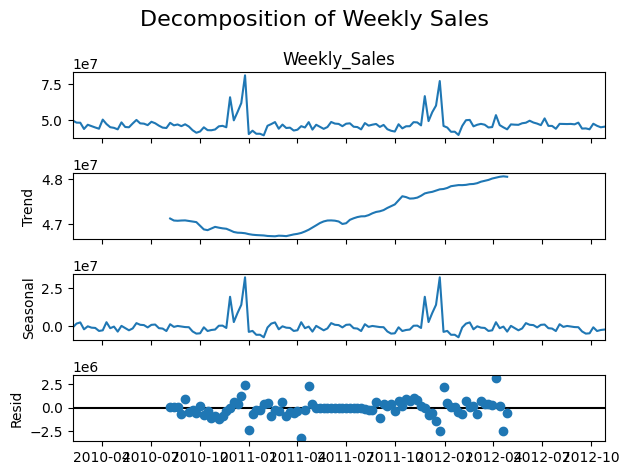

📌 Augmented Dickey-Fuller Test
ADF Statistic : -5.9083
p-value       : 0.0000


In [16]:
# Total penjualan per tanggal (seluruh store)
weekly_total = df.groupby('Date')['Weekly_Sales'].sum().sort_index()

# Decompose time series
decomposition = seasonal_decompose(weekly_total, model='additive', period=52)
decomposition.plot()
plt.suptitle("Decomposition of Weekly Sales", fontsize=16)
plt.tight_layout()
plt.show()

# Uji stasioneritas (ADF)
adf_test = adfuller(weekly_total)
print("Augmented Dickey-Fuller Test")
print(f"ADF Statistic : {adf_test[0]:.4f}")
print(f"p-value       : {adf_test[1]:.4f}")

##  Tahap 6: Modeling dengan Machine Learning
Model supervised learning digunakan untuk memprediksi `Weekly_Sales` berdasarkan fitur lain:
- **Linear Regression** sebagai baseline model.
- (Opsional) **Random Forest Regressor** untuk model non-linear dan kompleksitas lebih tinggi.
- Dilakukan split data train/test dan evaluasi menggunakan MAE, RMSE, dan R².

In [12]:
# Bangun model ARIMA otomatis
arima_model = auto_arima(weekly_total, seasonal=True, m=52, trace=True, suppress_warnings=True)
arima_model.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=4769.760, Time=14.11 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4844.691, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=4804.381, Time=1.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=4797.927, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=5462.768, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=inf, Time=6.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=4767.813, Time=5.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=4830.548, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=4769.801, Time=34.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=4772.938, Time=52.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=4777.852, Time=4.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=4779.475, Time=7.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=4769.157, Time=8.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=4779.845, Time=7.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=4783.296, Time=8.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,0)[52] intercept   : AIC=4780.613, Time=4.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,0)[52] intercept   : AIC=4781.038, Time=11.71 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(1,0,0)[52] intercept   : AIC=4773.351, Time=13.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[52]             : AIC=4797.052, Time=3.28 sec

Best model:  ARIMA(2,0,2)(1,0,0)[52] intercept
Total fit time: 186.226 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -2376.907
Date:                             Sun, 20 Apr 2025   AIC                           4767.813
Time:                                     08:33:59   BIC                           4788.553
Sample:                                 02-05-2010   HQIC                          4776.241
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.103e+07   1.59e-08   1.95e+15      0.000     3.1e+07     3.1e+07
ar.L1         -0.8263      0.277     -2.982      0.003      -1.370      -0.283
ar.L2         -0.1655      0.411     -0.403      0.687      -0.971       0.640
ma.L1          1.2206      0.284      4.302      0.000       0.665       1.777
ma.L2          0.6215      0.272      2.282      0.022       0.088       1.155
ar.S.L52       0.6713      0.041     16.271      0.000       0.590       0.752
sigma2      2.389e+13   1.82e-14   1.31e+27      0.000    2.39e+13    2.39e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               891.56
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.62e+44. Standard errors may be unstable.
"""

##  Tahap 7: Forecasting dengan ARIMA
Model time series ARIMA dibangun untuk prediksi jangka pendek/mingguan:
- Menggunakan `auto_arima` untuk memilih parameter terbaik (p, d, q).
- Model mempertimbangkan seasonality mingguan (`m=52`).
- Hasil prediksi dibandingkan dengan data aktual melalui visualisasi.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


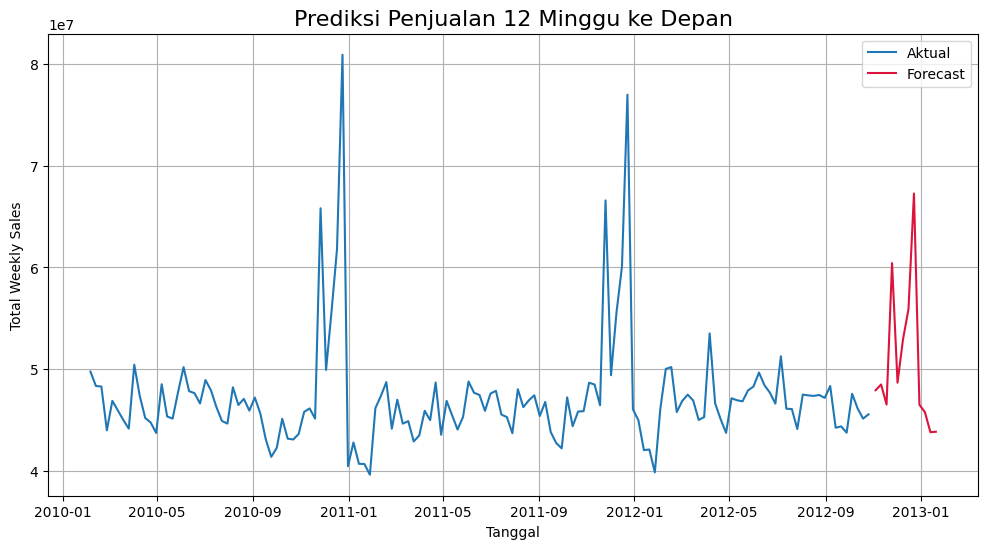

In [17]:
# Prediksi 12 minggu ke depan
n_weeks = 12
forecast = arima_model.predict(n_periods=n_weeks)
forecast_dates = pd.date_range(weekly_total.index[-1], periods=n_weeks+1, freq='W')[1:]

# Plot prediksi
plt.figure(figsize=(12,6))
plt.plot(weekly_total, label='Aktual')
plt.plot(forecast_dates, forecast, label='Forecast', color='crimson')
plt.title('Prediksi Penjualan 12 Minggu ke Depan', fontsize=16)
plt.xlabel('Tanggal')
plt.ylabel('Total Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


## Tahap 8: Evaluasi Model
Evaluasi model dilakukan dengan beberapa metrik:
- **MAE (Mean Absolute Error)**: Rata-rata kesalahan absolut.
- **RMSE (Root Mean Squared Error)**: Akar rata-rata kesalahan kuadrat.
- **R² Score**: Seberapa baik model menjelaskan variasi data.

# Rumus Matematika yang Digunakan

## 1. Mean Absolute Error (MAE)

MAE mengukur rata-rata selisih absolut antara nilai aktual dan nilai prediksi.

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

---

## 2. Root Mean Squared Error (RMSE)

RMSE menghitung akar dari rata-rata kuadrat selisih antara nilai aktual dan nilai prediksi.

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

---

## 3. Coefficient of Determination (R² Score)

R² mengukur seberapa baik model menjelaskan variasi dalam data aktual.

$$
R^2 = 1 - \frac{ \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }{ \sum_{i=1}^{n} (y_i - \bar{y})^2 }
$$

**Keterangan:**

- \( $y_i$ \) adalah nilai aktual ke-i  
- \( $\hat{y}_i$ \) adalah nilai prediksi ke-i  
- \( $\bar{y}$ \) adalah rata-rata dari semua nilai aktual

---

## 4. Uji Stasioneritas - Augmented Dickey-Fuller Test

Digunakan untuk menguji apakah sebuah data time series bersifat stasioner atau tidak.

Hipotesis:

- \( H_0 \): Data **tidak stasioner**  
- \( H_1 \): Data **stasioner**

Keputusan:

Jika nilai **p-value < 0.05**, maka tolak \( H_0 \), sehingga data dianggap stasioner.

---

## 5. Persamaan Linear Regression

Model regresi linear digunakan untuk memprediksi variabel target berdasarkan kombinasi fitur.

$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p
$$

**Keterangan:**

- \( $\hat{y}$ \) adalah hasil prediksi  
- \( $\beta_0 $\) adalah intercept (titik potong)  
- \( $\beta_1, \beta_2, ..., \beta_p $\) adalah koefisien regresi  
- \( $x_1, x_2, ..., x_p $\) adalah fitur (variabel input)

---

## 6. Model ARIMA (p, d, q)

Model ARIMA digunakan untuk forecasting data deret waktu (time series) dengan tiga parameter:

- \( p \): komponen Auto-Regressive (AR)  
- \( d \): jumlah differencing agar data menjadi stasioner  
- \( q \): komponen Moving Average (MA)

Bentuk umum dari model ARIMA:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q}
$$

**Keterangan:**

- \($ y_t $ \): nilai pada waktu ke-t  
- \( $\phi$ \): parameter AR  
- \( $\theta$ \): parameter MA  
- \( $\epsilon_t$ \): error acak (white noise)

---
